In [1]:
import numpy as np
import pandas as pd
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def simulate_beta_posterior(trials, beta_prior_a, beta_prior_b):
    num_successes = np.sum(trials)
    posterior_draws = np.random.beta(
        num_successes + beta_prior_a
        , len(trials) - num_successes + beta_prior_b
        , 10000
        )
    
    return posterior_draws

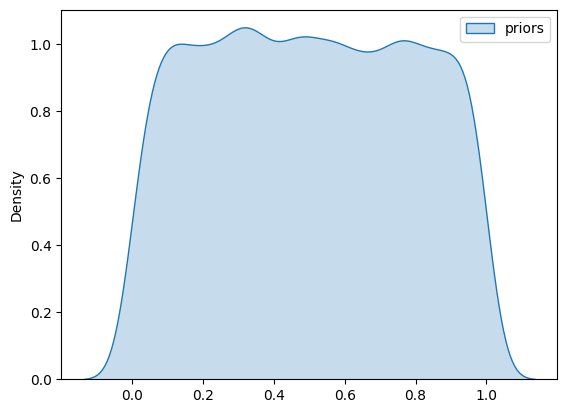

In [13]:
# prior assumption is that ctr for previous campaigns was around 15% with upper and lower bounds of 5% and 30%
prior_draws = np.random.beta(1, 1, 10000)

sns.kdeplot(prior_draws, fill = True, label = 'priors')
plt.legend()
plt.show()

In [5]:
df = pd.read_csv('sheet3.csv')
df.columns = ['CAMPAIGN', 'PURCHASE']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25251 entries, 0 to 25250
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CAMPAIGN  25251 non-null  object
 1   PURCHASE  25251 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 394.7+ KB


In [6]:
# df = pd.read_csv('starter_pack_abtest.csv')
# print(df.head())

A_clicks = df.loc[df['CAMPAIGN'] == 'Control', 'PURCHASE']
B_clicks = df.loc[df['CAMPAIGN'] == '5dollar', 'PURCHASE']

print(A_clicks.shape)
print(B_clicks.shape)

(12612,)
(12639,)


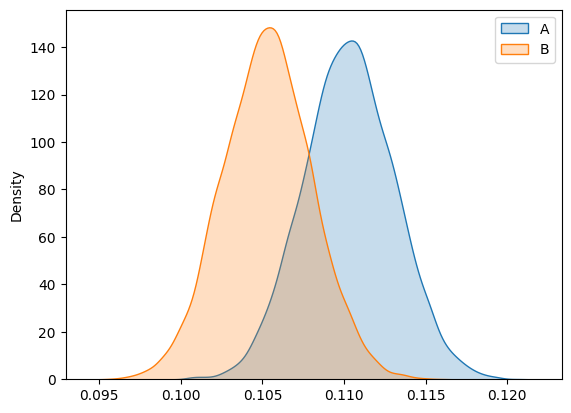

In [11]:
A_posterior = simulate_beta_posterior(A_clicks, 1, 1)
B_posterior = simulate_beta_posterior(B_clicks, 1, 1)

sns.kdeplot(A_posterior, fill = True, label = 'A')
sns.kdeplot(B_posterior, fill = True, label = 'B')
plt.legend()
plt.show()

With 0.9 probability, group A is better by [-0.00176749  0.01114002] percentage points


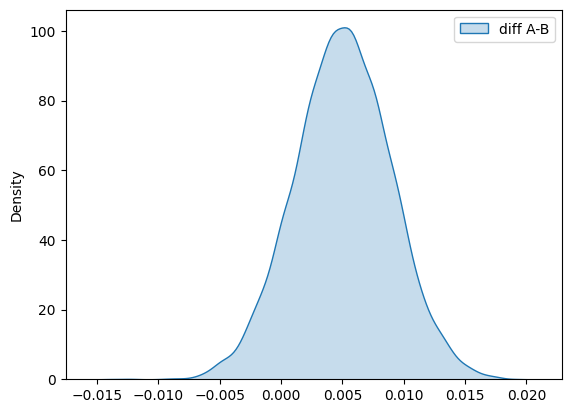

In [14]:
diff = A_posterior - B_posterior

hdi = 0.9
interval = az.hdi(diff, hdi)
print(f'With {hdi} probability, group A is better by {interval} percentage points')

sns.kdeplot(diff, fill = True, label = 'diff A-B')
plt.legend()
plt.show()

In [20]:
print(f'Probability of A being better than B: {(diff > 0).mean()}')

opposite_prob = (diff < 0).mean()
metric = 'Purchases'
loss = diff[diff < 0].mean()
print(f'Expected loss in {metric} if the {opposite_prob} probability of the opposite scenario materializes: {loss}')

Probability of A being better than B: 0.8993
Expected loss in Purchases if the 0.1007 probability of the opposite scenario materializes: -0.0019281483428622613


# Revenue
### As we're testing different price points, we have to account for the revenue generated by both versions. Even if B is worse by up to 1% in terms of purchases, it's also priced higher

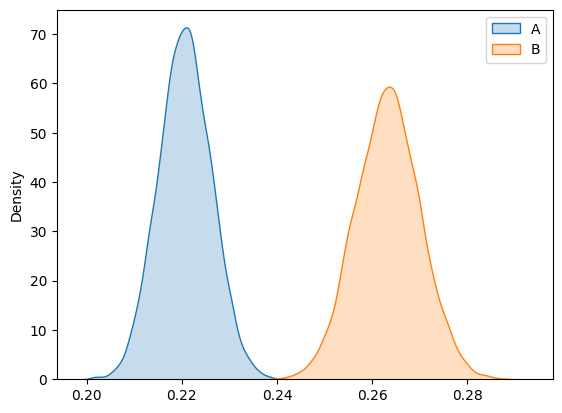

In [21]:
revenue_per_pack_A = 2
revenue_per_pack_B = 2.5

rev_A = A_posterior * revenue_per_pack_A
rev_B = B_posterior * revenue_per_pack_B

sns.kdeplot(rev_A, fill = True, label = 'A')
sns.kdeplot(rev_B, fill = True, label = 'B')
plt.legend()
plt.show()

array([<Axes: title={'center': '99.0% HDI'}>], dtype=object)

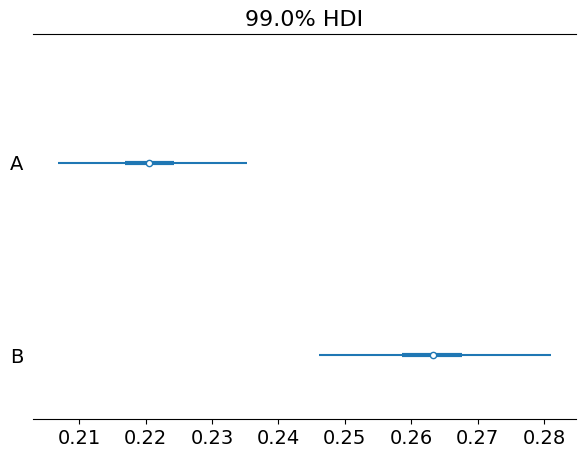

In [26]:
az.plot_forest({"A": rev_A, "B": rev_B}, kind='forestplot', combined = True, hdi_prob=0.99, figsize=(7, 5))

# Loss of conversions and cannibalization
### The additional generated revenue definitely looks better
### However, the Starter pack is a main first conversion mechanic and it's crucial we don't lose any potential payers there as this might poise a risk to long-term LTV down the road

In [41]:
df_iaps = pd.read_csv('sheet4.csv')
print(df_iaps.shape)
print(df_iaps.head())

(7596, 9)
      PLATFORM ACTIVE_DATE COUNTRY     PACK_NAME  PRICE_PAID  REVENUE_EUR  \
0          iOS  2021-11-21      EC    other_pack        9.99      6.20455   
1  Google Play  2021-11-21      CH  starter_pack        2.00      1.19407   
2  Google Play  2021-11-19      GB    other_pack        4.49      3.02587   
3          iOS  2021-11-19      US    other_pack        4.99      3.07760   
4          iOS  2021-11-19      US    other_pack        2.99      1.84656   

  PURCHASE_LOCATION CAMPAIGN  PURCHASE_NEW  
0         IAP Store  5dollar             0  
1         IAP Store  Control             1  
2         IAP Store  5dollar             0  
3         IAP Store  5dollar             0  
4         IAP Store  Control             0  


In [52]:
# First conversions on packs priced similarly to the original $2 starter_pack
# test group actually shows more first purchases of $2 packs, meaning players who didn't buy the more expensive starter pack, went to $2 packs anyway
df_iaps.loc[(df_iaps['PACK_NAME'] != 'starter_pack') & ((df_iaps['PRICE_PAID'] == 1.99) | (df_iaps['PRICE_PAID'] == 2.00)), ['PRICE_PAID', 'CAMPAIGN']].groupby('CAMPAIGN').count()

,PRICE_PAID
CAMPAIGN,
5dollar,532
Control,494
